In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

### Load dataset - MovieLens

In [8]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv("ratings.csv")
tags = pd.read_csv("tags.csv")

movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [10]:
tags = tags.fillna("")

#### Ratings data reduced to 5 million due to pivot table error

In [11]:
ratings_5m = ratings[:5000000]
ratings_5m

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580
...,...,...,...,...
4999995,34395,1805,2.5,1138696726
4999996,34395,1826,0.5,1138309379
4999997,34395,1835,2.5,1138262152
4999998,34395,1863,2.0,1138308785


### User-item Matrix

In [12]:
user_movies_data = ratings_5m.pivot(index='movieId', columns='userId', values='rating').fillna(0)

In [13]:
user_movies_data.shape

(20402, 34395)

In [14]:
tags1 = tags.groupby(['movieId'])['tag'].apply(' '.join).reset_index()
tags1 = tags1.rename(columns={'tag':'tag_metadata'})
tags1

,movieId,tag_metadata
0,1,Watched computer animation Disney animated fea...
1,2,time travel adapted from:book board game child...
2,3,old people that is actually funny sequel fever...
3,4,chick flick revenge characters chick flick cha...
4,5,Diane Keaton family sequel Steve Martin weddin...
...,...,...
19540,131054,dinosaurs
19541,131082,documentary Yoshitomo Nara
19542,131164,Vietnam War
19543,131170,alternate reality


In [15]:
movies2 = pd.merge(movies, tags1, how='left', on=['movieId'])
movies2 = movies2.fillna("")
movies2 = movies2.rename(columns={'tag': 'tag_metadata'})
movies2

,movieId,title,genres,tag_metadata
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Watched computer animation Disney animated fea...
1,2,Jumanji (1995),Adventure|Children|Fantasy,time travel adapted from:book board game child...
2,3,Grumpier Old Men (1995),Comedy|Romance,old people that is actually funny sequel fever...
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,chick flick revenge characters chick flick cha...
4,5,Father of the Bride Part II (1995),Comedy,Diane Keaton family sequel Steve Martin weddin...
...,...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy,
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy,
27275,131258,The Pirates (2014),Adventure,bandits Korea mutiny pirates whale
27276,131260,Rentun Ruusu (2001),(no genres listed),


### Content Filtering
#### TF-IDF Vectorizer for tag_metadata

In [16]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies2['tag_metadata'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), movies2.index.tolist())
tfidf_df.shape

(27278, 23863)

In [17]:
svd = TruncatedSVD(n_components=2000)
latent_matrix_1 = svd.fit_transform(tfidf_df)

In [18]:
latent_matrix_1_1 = latent_matrix_1[:20402]
latent_matrix_1_1.shape

(20402, 2000)

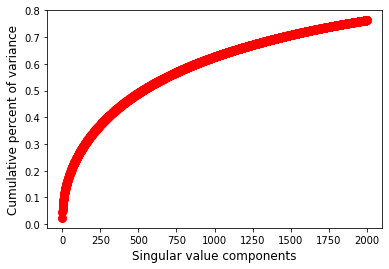

In [19]:
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

In [20]:
n = 2001
latent_matrix_1_df = pd.DataFrame(latent_matrix_1[:,0:n], index=movies2['title'].tolist())
latent_matrix_1_df.shape

(27278, 2000)

In [21]:
latent_matrix_1_df_1 = latent_matrix_1_df[:20402]
latent_matrix_1_df_1.shape

(20402, 2000)

### Collaborative Filtering
#### User-item matrix

In [22]:
svd_user_movies = TruncatedSVD(n_components = 1000)
latent_matrix_2 = svd_user_movies.fit_transform(user_movies_data)

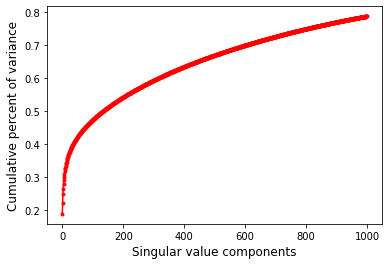

In [23]:
explained = svd_user_movies.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

In [24]:
n=1001
latent_matrix_2_df = pd.DataFrame(latent_matrix_2, index=movies2['title'][:20402].tolist())
latent_matrix_2_df.shape

(20402, 1000)

### Cosine Similarity

In [26]:
a_1 = np.array(latent_matrix_1_df_1.loc['Sleepless in Seattle (1993)']).reshape(1, -1)
a_2 = np.array(latent_matrix_2_df.loc['Sleepless in Seattle (1993)']).reshape(1, -1)

score_1 = cosine_similarity(latent_matrix_1_1, a_1).reshape(-1)
score_2 = cosine_similarity(latent_matrix_2, a_2).reshape(-1)

hybrid = 0.7*score_1 + 0.3*score_2

dictDF = ({'content': score_1, 'collaborative': score_2, 'hybrid': hybrid})
similar_movies = pd.DataFrame(dictDF, index=latent_matrix_2_df.index)

similar_movies.sort_values('hybrid', ascending=False, inplace=True)
similar_movies[1:].head(10)

,content,collaborative,hybrid
You've Got Mail (1998),0.900355,0.108334,0.662749
Forrest Gump (1994),0.562100,0.556772,0.560501
Joe Versus the Volcano (1990),0.736178,0.032700,0.525135
French Kiss (1995),0.541986,0.445008,0.512892
Turner & Hooch (1989),0.642216,0.137212,0.490715
"Money Pit, The (1986)",0.662159,0.086619,0.489497
Big (1988),0.617185,0.139473,0.473872
Volunteers (1985),0.591626,0.164419,0.463464
I.Q. (1994),0.440373,0.412529,0.432020
Cast Away (2000),0.547256,0.141556,0.425546


### Content Filtering Recommendation System

In [27]:
def content_recommend_similar_movies(title):
    a_1 = np.array(latent_matrix_1_df_1.loc[title]).reshape(1, -1)
    a_2 = np.array(latent_matrix_2_df.loc[title]).reshape(1, -1)

    score_1 = cosine_similarity(latent_matrix_1_1, a_1).reshape(-1)
    score_2 = cosine_similarity(latent_matrix_2, a_2).reshape(-1)

    hybrid = 0.7*score_1 + 0.3*score_2

    dictDF = {'content': score_1, 'collaborative': score_2, 'hybrid': hybrid}
    similar_movies = pd.DataFrame(dictDF, index=latent_matrix_2_df.index)

    similar_movies.sort_values('content', ascending=False, inplace=True)
    recommended_movies = similar_movies.index[1:11]
    recommended_movies = pd.DataFrame(recommended_movies, columns=['Recommended Movies'])
    
    return recommended_movies

In [28]:
content_recommend_similar_movies('Jumanji (1995)')

,Recommended Movies
0,Flubber (1997)
1,"Final Cut, The (2004)"
2,Mrs. Doubtfire (1993)
3,Fathers' Day (1997)
4,One Hour Photo (2002)
5,Jack (1996)
6,RV (2006)
7,"Good Morning, Vietnam (1987)"
8,Toys (1992)
9,World's Greatest Dad (2009)


### Collaborative Filtering Recommendation System

In [29]:
def collab_recommend_similar_movies(title):
    a_1 = np.array(latent_matrix_1_df_1.loc[title]).reshape(1, -1)
    a_2 = np.array(latent_matrix_2_df.loc[title]).reshape(1, -1)

    score_1 = cosine_similarity(latent_matrix_1_1, a_1).reshape(-1)
    score_2 = cosine_similarity(latent_matrix_2, a_2).reshape(-1)

    hybrid = 0.7*score_1 + 0.3*score_2

    dictDF = {'content': score_1, 'collaborative': score_2, 'hybrid': hybrid}
    similar_movies = pd.DataFrame(dictDF, index=latent_matrix_2_df.index)

    similar_movies.sort_values('collaborative', ascending=False, inplace=True)
    recommended_movies = similar_movies.index[1:11]
    recommended_movies = pd.DataFrame(recommended_movies, columns=['Recommended Movies'])
    
    return recommended_movies

In [30]:
collab_recommend_similar_movies('Jumanji (1995)')

,Recommended Movies
0,"Mask, The (1994)"
1,"Lion King, The (1994)"
2,Mrs. Doubtfire (1993)
3,Home Alone (1990)
4,Jurassic Park (1993)
5,Aladdin (1992)
6,Speed (1994)
7,"Santa Clause, The (1994)"
8,Waterworld (1995)
9,Batman Forever (1995)


### Hybrid (Content + Collaborative Filtering) Recommendation System

In [31]:
def hybrid_recommend_similar_movies(title):
    a_1 = np.array(latent_matrix_1_df_1.loc[title]).reshape(1, -1)
    a_2 = np.array(latent_matrix_2_df.loc[title]).reshape(1, -1)

    score_1 = cosine_similarity(latent_matrix_1_1, a_1).reshape(-1)
    score_2 = cosine_similarity(latent_matrix_2, a_2).reshape(-1)

    hybrid = 0.7*score_1 + 0.3*score_2

    dictDF = {'content': score_1, 'collaborative': score_2, 'hybrid': hybrid}
    similar_movies = pd.DataFrame(dictDF, index=latent_matrix_2_df.index)

    similar_movies.sort_values('hybrid', ascending=False, inplace=True)
    recommended_movies = similar_movies.index[1:11]
    recommended_movies = pd.DataFrame(recommended_movies, columns=['Recommended Movies'])
    
    return recommended_movies

In [32]:
hybrid_recommend_similar_movies('Jumanji (1995)')

,Recommended Movies
0,Mrs. Doubtfire (1993)
1,Flubber (1997)
2,"Final Cut, The (2004)"
3,Fathers' Day (1997)
4,Jack (1996)
5,One Hour Photo (2002)
6,RV (2006)
7,"Big White, The (2005)"
8,Best Defense (1984)
9,Toys (1992)


### Matrix Factorization Recommender

In [39]:
class MF():
    def __init__(self, R, K, alpha, beta, iterations):
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

    def train(self):
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])

        self.samples = [
        (i, j, self.R[i, j])
        for i in range(self.num_users)
        for j in range(self.num_items)
        if self.R[i, j] > 0
        ]

        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 20 == 0:
                print("Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    def mse(self):
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.get_rating(i, j)
            e = (r - prediction)

            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

    def get_rating(self, i, j):
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction
    
    def full_matrix(self):
        return mf.b + mf.b_u[:,np.newaxis] + mf.b_i[np.newaxis:,] + mf.P.dot(mf.Q.T)

In [42]:
R= np.array(ratings_5m.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0))

In [43]:
mf = MF(R, K=20, alpha=0.001, beta=0.01, iterations=50)
training_process = mf.train()
print()
print("P x Q:")
print(mf.full_matrix())
print()